In [2]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator ##
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Dropout,MaxPooling2D

import pickle

####  PARAMETERS 


In [3]:
path = 'data'
taille_image=32
testRatio = 0.2
valRatio = 0.2
imageDimensions= (taille_image,taille_image,3)
batchSizeVal= 50
epochsVal = 10
stepsPerEpochVal = 550

#### IMPORTING DATA/IMAGES FROM FOLDERS 

In [4]:
count = 0
images = []     # LIST CONTAINING ALL THE IMAGES 
classNo = []    # LIST CONTAINING ALL THE CORRESPONDING CLASS ID OF IMAGES 
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses = len(myList)
print("Importing Classes .......")
for x in range (0,noOfClasses):
    myPicList = os.listdir(path+"/"+str(x))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg,(32,32))
        images.append(curImg)
        classNo.append(x)
    print(x,end= " ")
print(" ")
print("Total Images in Images List = ",len(images))
print("Total IDS in classNo List= ",len(classNo))

Total Classes Detected: 10
Importing Classes .......
0 1 2 3 4 5 6 7 8 9  
Total Images in Images List =  43680
Total IDS in classNo List=  43680


#### CONVERT TO NUMPY ARRAY 

In [5]:
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)


(43680, 32, 32, 3)


#### SPLITTING THE DATA

In [6]:
X_train,X_test,y_train,y_test = train_test_split(images,classNo,test_size=testRatio)
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=valRatio)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(27955, 32, 32, 3)
(8736, 32, 32, 3)
(6989, 32, 32, 3)


#### PLOT BAR CHART FOR DISTRIBUTION OF IMAGES

[2831, 2806, 2803, 2800, 2776, 2799, 2852, 2780, 2766, 2742]


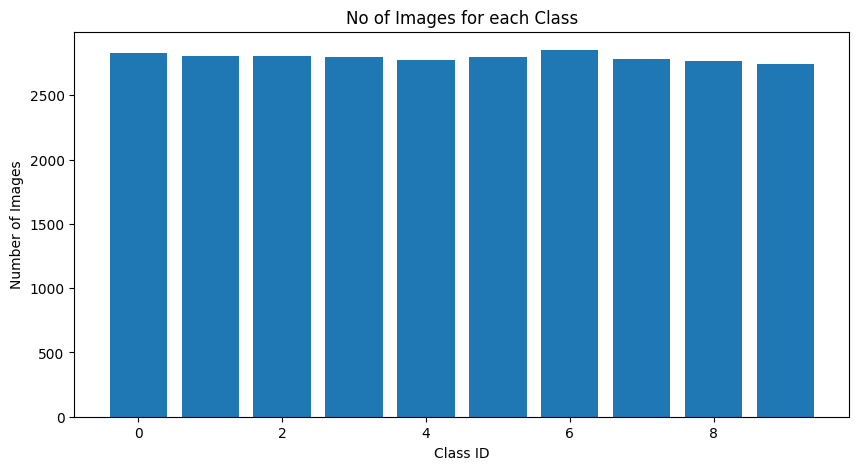

In [7]:
numOfSamples= []
for x in range(0,noOfClasses):
    #print(len(np.where(y_train==x)[0]))
    numOfSamples.append(len(np.where(y_train==x)[0]))
print(numOfSamples)
plt.figure(figsize=(10,5))
plt.bar(range(0,noOfClasses),numOfSamples)
plt.title("No of Images for each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

#### PREPOSSESSING FUNCTION FOR IMAGES FOR TRAINING 

In [8]:
def preProcessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img
    
def showImage(img, name='my-img'):
    plt.imshow(img,cmap='gray')
    plt.title(name)
    #plt.axis('off')
    plt.show()

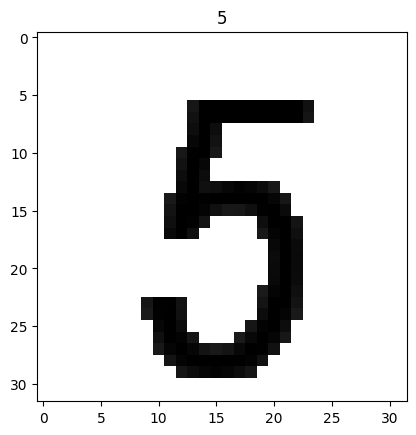

In [12]:
selectedImage=2000
img = preProcessing(X_train[selectedImage])
showImage(img, y_train[selectedImage]) 

#### preprocesss all images

In [13]:
X_train.shape

(27955, 32, 32, 3)

In [14]:
X_train= np.array(list(map(preProcessing,X_train)))
X_test= np.array(list(map(preProcessing,X_test)))
X_validation= np.array(list(map(preProcessing,X_validation)))

In [15]:
X_train.shape

(27955, 32, 32)

#### RESHAPE IMAGES 

In [16]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)

#### IMAGE AUGMENTATION 

In [17]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)

#### ONE HOT ENCODING OF MATRICES

In [18]:
 ##### [0, 0, 1]]  # Correspond à la classe 2
y_train = to_categorical(y_train,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)


#### CREATING THE MODEL 

In [19]:
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5,5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2,2)
    noOfNodes= 500

    model = Sequential()
    model.add((Conv2D(noOfFilters,sizeOfFilter1,input_shape=(imageDimensions[0],imageDimensions[1],1),activation='relu')))
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(noOfNodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))

    #model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
    return model
model = myModel()

In [20]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

#### STARTING THE TRAINING PROCESS

In [21]:
len(X_train)//batchSizeVal


559

In [22]:
history = model.fit(dataGen.flow(X_train,y_train,
                                 batch_size=batchSizeVal),
                                 epochs=epochsVal,
                                 validation_data=(X_validation,y_validation),
                                 shuffle=1)


Epoch 1/10


2025-12-03 23:08:57.584469: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


560/560 [==============================] - 27s 47ms/step - loss: 0.8361 - accuracy: 0.7087 - val_loss: 0.0432 - val_accuracy: 0.9903
Epoch 2/10
560/560 [==============================] - 26s 47ms/step - loss: 0.1839 - accuracy: 0.9380 - val_loss: 0.0197 - val_accuracy: 0.9927
Epoch 3/10
560/560 [==============================] - 27s 48ms/step - loss: 0.1182 - accuracy: 0.9603 - val_loss: 0.0142 - val_accuracy: 0.9957
Epoch 4/10
560/560 [==============================] - 27s 48ms/step - loss: 0.0899 - accuracy: 0.9708 - val_loss: 0.0043 - val_accuracy: 0.9994
Epoch 5/10
560/560 [==============================] - 26s 47ms/step - loss: 0.0756 - accuracy: 0.9754 - val_loss: 0.0027 - val_accuracy: 0.9993
Epoch 6/10
560/560 [==============================] - 27s 48ms/step - loss: 0.0580 - accuracy: 0.9808 - val_loss: 0.0044 - val_accuracy: 0.9990
Epoch 7/10
560/560 [==============================] - 27s 48ms/step - loss: 0.0565 - accuracy: 0.9821 - val_loss: 0.0020 - val_accuracy: 0.9994
Epo

#### PLOT THE RESULTS  

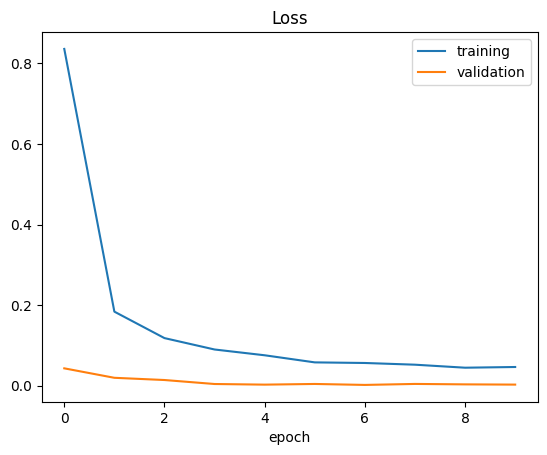

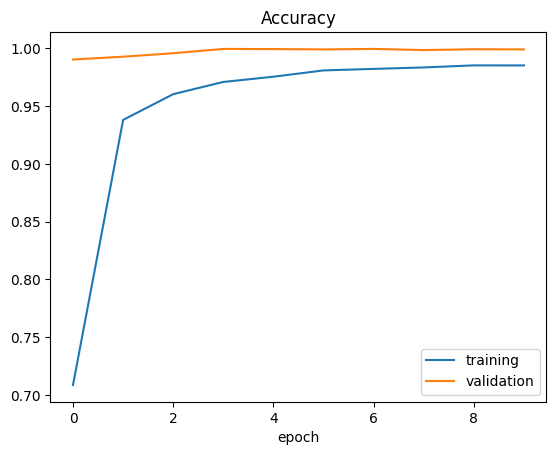

In [23]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

#### EVALUATE USING TEST IMAGES

In [24]:
score = model.evaluate(X_test,y_test,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.003069415455684066
Test Accuracy = 0.9991987347602844


#### SAVE THE TRAINED MODEL 

In [25]:
pickle_out= open("model_trained.p", "wb")
pickle.dump(model,pickle_out)
pickle_out.close()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........3
.........4
.........5
.........6
.........7
........

In [26]:
model.save('model_trained.keras')
model.save('model_trained.h5')

